# Pre-class work

We consider the eczema medical trial data set again. This time we will compare which of 2 models explain the observed data best.

* Model 1: All studies have the same probability of success.
* Model 2: A hierarchical model where the probability of success in each study is drawn from a beta prior distribution with unknown $\alpha$ and $\beta$ parameters.


|Study          | Treatment group |   Control group  |
|---------------|-----------------|------------------|
|Di Rienzo 2014 |     20 / 23     |        9 / 15    |
|Galli 1994     |     10 / 16     |       11 / 18    |
|Kaufman 1974   |     13 / 16     |        4 / 10    |
|Qin 2014       |     35 / 45     |       21 / 39    |
|Sanchez 2012   |     22 / 31     |       12 / 29    |
|Silny 2006     |      7 / 10     |        0 / 10    |
|**Totals**     |    107 / 141    |       57 / 121   |


**Model 1:**

* For each group (treatment and control), all 6 studies have the same fixed, but unknown, probability of success, $\theta_t,\theta_c\in[0,1]$.
* The data follow a binomial distribution in each study, conditioned on the probability of success — $\theta_t$ for treatment or $\theta_c$ for control.
* The priors over $\theta_t$ and $\theta_c$ are uniform.

These assumptions lead to the following model.

* Likelihood: $\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta, n_i)$, where $s_i$ is the number of successful recoveries, $f_i$ is the number of failures (did not recover), and $n_i=s_i+f_i$ the number of patients.

* Prior: $\text{Beta}(\theta\,|\,1,1)$ for both $\theta_t$ and $\theta_c$.

* Posterior for treatment group: $\text{Beta}(\theta_t\,|\,108, 35)$.

* Posterior for control group: $\text{Beta}(\theta_c\,|\,58, 65)$.

Since we have closed-form solutions for the posteriors, we can calculate the marginal likelihood by rearranging Bayes' equation: (marginal likelihood) = (likelihood) x (prior) / (posterior).

$$ P(\text{data}) = \left[\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta, n_i) \right] \text{Beta}(\theta\,|\,\alpha_0,\beta_0) \,/\, \text{Beta}(\theta\,|\,\alpha_1,\beta_1)$$
where $\alpha_0=1$ and $\beta_0=1$ are the parameters of the prior, and $\alpha_1$ and $\beta_1$ are the parameters of the posterior beta distribution.

Since all factors involving $\theta$ cancel out, we are just left with the normalization constants of the likelihood, the prior and the posterior:

$$\begin{aligned}
P(\text{data})
&= \left[ \prod_{i=1}^6 \left(\begin{array}{c}s_i+f_i \\ s_i\end{array}\right) \right] \frac{\text{B}(\alpha_1,\beta_1)}{\text{B}(\alpha_0,\beta_0)} \\
&= \left[\prod_{i=1}^6 \frac{1}{(s_i+f_i+1)\text{B}(s_i+1,f_i+1)}\right] \frac{\text{B}(\alpha_1,\beta_1)}{\text{B}(\alpha_0,\beta_0)}
\end{aligned}$$

We usually compute the log of the marginal likelihood since the results can vary over many orders of magnitude.

## Task 1

1. Take the log of the marginal likelihood above.
2. Complete the Python function below to calculate the log marginal likelihood.
3. You can use the built-in function `scipy.special.betaln(a,b)` to compute $\log \text{B}(a,b)$.

In [1]:
from scipy.special import betaln
from numpy import log
import numpy as np
treatdata = np.matrix([[20, 10, 13, 35, 22, 7], 
                       [3, 6, 3, 10, 9, 3]])
controldata = np.matrix([[9, 11, 4, 21, 12, 0],
                         [6, 7, 6, 18, 17, 10]])

def log_beta_binomial_marginal_likelihood(alpha0, beta0, data):
    '''
    Compute the log marginal likelihood of the beta-binomial model
    for the eczema data set.

    Arguments:

        alpha0, beta0: prior beta distribution parameters.

        data: 2 x n matrix, where n is the number of samples from
          the binomial distribution. This means the first row contains
          the success counts and the second row the failure counts
          of the samples.
    '''
    
    return (sum([ - np.log(sum(np.array(i)[0]) + 1) - betaln(1 + np.array(i)[0][0], 1 + np.array(i)[0][1]) for i in np.transpose(data)])
            + betaln(alpha0 + np.matrix.sum(data[0,:]), beta0 + np.matrix.sum(data[1,:]) - betaln(alpha0, beta0)))

print(log_beta_binomial_marginal_likelihood(1,1, treatdata))
print(log_beta_binomial_marginal_likelihood(1,1, controldata))

-14.00975183183273
-18.99394828290636


**Model 2:**

* For each group (intervention and control), each of the 6 studies has a different probability of success.
* Each probability of success is drawn from a beta prior with unknown parameters $\alpha$ and $\beta$.
* Since $\alpha$ and $\beta$ are unknown, we put a broad hyperprior on them — we choose the Gamma(2, 0.5) distribution, which is shown below.

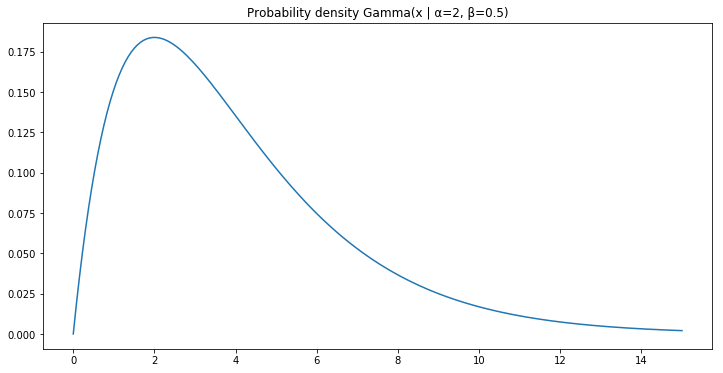

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts

plot_x = np.linspace(0, 15, 200)
plot_y = sts.gamma(a=2, scale=1/0.5).pdf(plot_x)
plt.figure(figsize=(12, 6))
plt.plot(plot_x, plot_y)
plt.title(r'Probability density Gamma(x | α=2, β=0.5)')
plt.show()

These assumptions lead to the following model:

* Likelihood: $\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta_i, n_i)$, where $s_i$ is the number of successful recoveries, $f_i$ is the number of failures (did not recover), and $n_i=s_i+f_i$ the number of patients. Note that each study has its own $\theta_i$, whereas Model 1 had the same $\theta$ for all 6 studies.

* Prior: $\prod_{i=1}^6 \text{Beta}(\theta_i\,|\,\alpha,\beta)$.

* Hyperprior: $P(\alpha,\beta) = \text{Gamma}(\alpha\,|\,2,0.5)\,\text{Gamma}(\beta\,|\,2,0.5)$.

This model has 8 parameters (for each of the treatment and control groups), namely $\theta_1, \ldots, \theta_6$, $\alpha$, and $\beta$.

Since the posterior does not have a closed-form analytical solution, we have to calculate the marginal likelihood by integrating out all of the parameters in the model.

$$ P(\text{data}) = \int_0^{\infty} \int_0^{\infty} \int_0^1\cdots\int_0^1 \left[\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta_i,n_i)\,\text{Beta}(\theta_i\,|\,\alpha,\beta) \right] P(\alpha,\beta)\ \text{d}\theta_6\cdots\text{d}\theta_1\,\text{d}\beta\,\text{d}\alpha$$

This looks like a crazy 8-dimensional integral, but we can actually integrate out the $\theta_i$ analytically, leaving a 2-dimensional integral over $\alpha$ and $\beta$.

First, note that $P(\alpha,\beta)$ does not contain $\theta_i$, so we can move it outside of the $\theta_i$ integrals.

$$ = \int_0^{\infty} \int_0^{\infty} P(\alpha,\beta) {\color{blue}{\int_0^1\cdots\int_0^1 \left[\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta_i,n_i)\,\text{Beta}(\theta_i\,|\,\alpha,\beta) \right] \ \text{d}\theta_6\cdots\text{d}\theta_1}}\,\text{d}\beta\,\text{d}\alpha$$

Next, since there are no factors containing two different $\theta_i$ variables, we can rearrange the integrals and the products (the blue part) like this:

$$ = \int_0^{\infty} \int_0^{\infty} P(\alpha,\beta) {\color{blue}{\left[\prod_{i=1}^6 \int_0^1\text{Binomial}(s_i\,|\,\theta_i,n_i)\,\text{Beta}(\theta_i\,|\,\alpha,\beta)\,\text{d}\theta_i\right]}}\,\text{d}\beta\,\text{d}\alpha$$

**Note that we cannot always swap products and integrals.**


Since the beta distribution is conjugate to the binomial, the blue integrals above can be evaluated analytically (much like we did for Model 1), to get

$$ = \int_0^{\infty}\int_0^{\infty} P(\alpha,\beta) \left[\prod_{i=1}^6 \frac{1}{(s_i+f_i+1)\,\text{B}(s_i+1,f_i+1)}\,\frac{\text{B}(\alpha+s_i, \beta+f_i)}{\text{B}(\alpha,\beta)}\right]\,\text{d}\beta\,\text{d}\alpha$$

Finally, move all the factors that do not depend on $\alpha$ or $\beta$ out of the integrals.

$$ = \left[\prod_{i=1}^6 (s_i+f_i+1)\,\text{B}(s_i+1,f_i+1) \right]^{-1} \int_0^{\infty}\int_0^{\infty} P(\alpha,\beta)\, \text{B}(\alpha,\beta)^{-6} \prod_{i=1}^6 \text{B}(\alpha+s_i, \beta+f_i)\ \text{d}\beta\,\text{d}\alpha$$

Unfortunately we cannot evaluate the remaining integrals analytically, so we resort to a numerical calculation.

## Task 2

1. Write a Python function to compute the value of the integral above using the `scipy.integrate.dblquad` function.
2. Write a Python function to compute the marginal likelihood of the hierarchical model for the medical trials data set.

In [30]:
from scipy.integrate import dblquad
from scipy.stats import gamma
from scipy.integrate import nquad
import scipy.stats as sts

f = lambda a, b: gamma.pdf(2, 0.5)

data_treatment = np.array([[20, 10, 13, 35, 22, 7], [3, 6, 3, 10, 9, 3]])
data_control = np.array([[9, 11, 4, 21, 12, 0], [6, 7, 6, 18, 17, 10]])


# The integrand for the double integral over a (alpha) and b (beta).
def integrand(a, b, data):
    n = data.shape[1]
    integrand = (sts.gamma(a=2, scale=1/0.5).pdf(a) *
                 sts.gamma(a=2, scale=1/0.5).pdf(b) *
                 special.beta(a, b) ** -n *
                 np.product(special.beta(a + data[0,:], b + data[1,:])))
    return integrand

integrand(1,1, treatdata)

def hierarchical_marginal_likelihood(data):

    constant = np.product((data[0,:] + data[1,:] + 1) * special.beta(data[0,:] + 1, data[1,:] + 1))**(-1)
    integral, error = nquad(integrand, ranges=[(0, 50), (0, 50)], args=[data])

    return {'marginal_likelihood': integral / constant, # Value of the integral
            'error': error / constant} # Numerical error in integral

hierarchical_marginal_likelihood(data_treatment)

{'marginal_likelihood': 3.880524730708608e-65, 'error': 2.3114773030226638e-65}